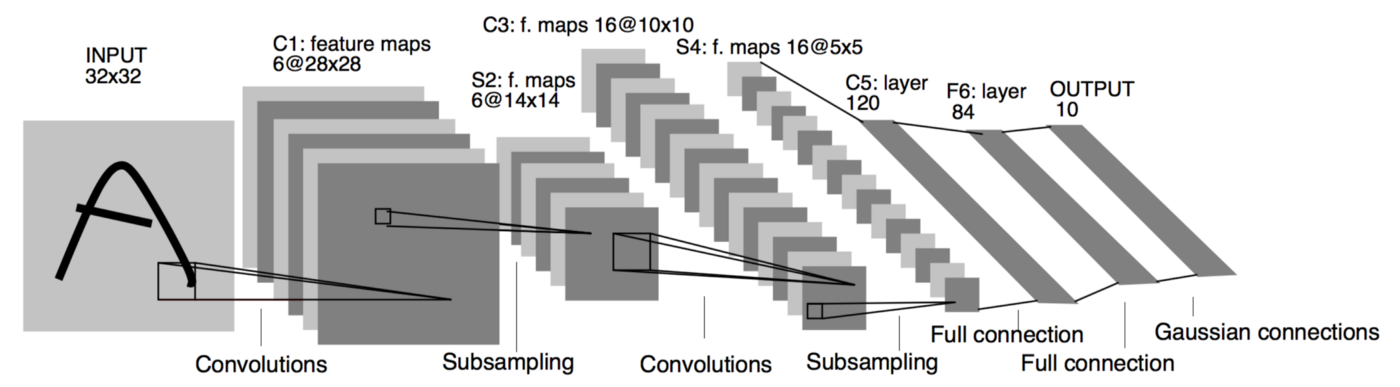

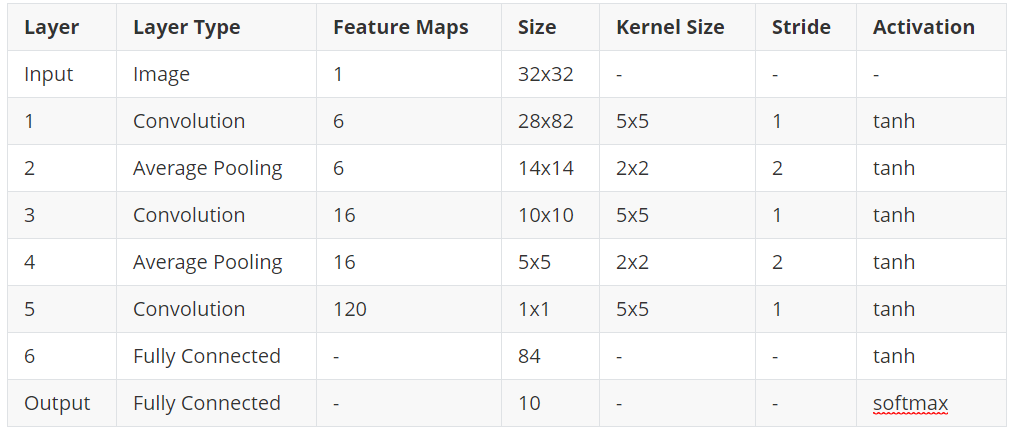

In [ ]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
import torchvision.datasets

In [ ]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

In [ ]:
len(y_train), len(y_test)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

Первое отличие заключается в том, что, в отличие от полносвязанной сети, которая видела картинку как один вектор длинный, мы хотим в конволюционную сеть передавать картинку как трёхмерный тензор. Первый канал -- это глубина картинки, в черно-белой картинке это 1 канал с яркостью серого пикселя. А в RGB картинке будут RGB каналы. Соответственно, мы должны нашу картинку, которая на вход пришла (она просто "28 на 28"), разжать до "1 на 28 на 28". Вот мы это и делаем -- мы делаем X_train.unsqueeze, а здесь ставим индекс: "а в каком же измерении мы хотим разжать". То есть X_train у нас -- тензор из 60 000 картинок 28 на 28, а мы хотим чтобы было 60 000 на 1 на 28 на 28, и то же самое мы делаем с тестом.


In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train.shape

"LeNet5" -- она называется потому, что там 5 обучаемых слоёв -- три свёртки и два полносвязанных слоя, у нас будет две свёртки и три полносвязанных слоя. Начнём определять слои. Точно так же, как у ЛеКуна, у нас будет первый слой, который принимает один канал на вход, потому что картинка у нас одномерная (там один канал) -- не RGB, а grayscale, и на выходе будет 6 каналов. Но в отличие от ЛеКуна, к которому приходила картинка 32 на 32, у нас картинка от 28 на 28. И если мы, точно так же, как в оригинальной сети, применим конволюцию 5 на 5 и без паддингов, у нас получится картинка "28 - 4", соответственно, будет 24 пикселя на 24, а мы бы хотели, чтобы после первой конволюции картинка была бы 28 на 28. Если вы не хотите терять размерность картинки, то вам нужно установить некоторый паддинг, чтобы свёртки выходили за границы картинки и получившееся на выходе изображение или тензор был бы такого же размера. В размере 5 на 5 у вас свёртки должны выходить на 2 пикселя за размер изображения, тогда итоговый тензор будет иметь такой же размер. Если бы у нас были свёртки 3 на 3, то нам нужно было бы выходить на один пиксель, и тогда бы количество этих свёрток, которые мы прикладываем к изображению, было бы равно, как раз, размеру изображения. Здесь мы поставим паддинг "2" чтобы сохранить размер. 

Итак, нам нужно применить наш первый конволюционный слой, он называется "Conv2d", потому что он двухмерный. Если бы у нас были какие-нибудь трёхмерные изображения, например, мозга человека, и мы бы должны были идти по объёму, то у нас было бы "Conv3d", который в PyTorch тоже есть. Но у нас картинка плоская, соответственно мы будем ходить в двухмерном пространстве. В этом Conv2d есть много параметров, мы должны использовать количество входных каналов -- обязательно проставить, что их будет "1". Выходных каналов будет 6. Размер ядра свёртки -- "5", если у вас вдруг свёртка не симметричная (бывают растянутые свёртки), то тут можно указать tuple из двух чисел, но у нас свёртка будет квадратная, 5 на 5, соответственно, мы просто укажем "5". И дальше мы должны указать паддинг "2", потому что у нас свёртка должна выходить за границы. Сделали вот такой слой, свой назовём его conv1, потом мы его применим. Далее мы должны применить активизацию. Активации в LeNet -- тангенсы, соответственно мы применяем "torch.nn.Tanh". 

После этого -- первый пулинг, называется "pool1", это "average pooling". Напоминаю, что average pooling не так уж популярны, они используются обычно в конце архитектуры чтобы сжать всё изображение, которое получилось, а в середине сети обычно используется max pooling, но в силу традиций здесь тоже мы используем average pooling 2d. У него "kernel_size" -- 2, потому что это пулинг 2 на 2, и "stride" -- 2, потому что он применяется без пересечений. Этот пулинг нам сожмёт изображение от 28 на 28 до 14 на 14. 

Далее мы делаем примерно всё то же самое: Conv2d -- снова свёртка, входных каналов 6, потому что было здесь выходных каналов 6, и выходных каналов у этой свёртки 16. Так было в оригинальной архитектуре -- точно такой же kernel size 5, padding 0, потому что оригинальные падинги не выходили за размер изображения. Снова активация тангенсом, снова пулинг. Из нашего изображения, которое было 14 на 14, свёртка сделает изображение 10 на 10, потому что отрежет по 2 пикселя с каждой стороны, а пулинг нам сделает изображение 5 на 5. Соответственно после этого average pooling 2d у нас изображение -- 5 на 5. 

А далее мы что сделаем? Далее мы растянем изображение в один вектор (это мы делаем в функции "forward", а пока мы представим, что мы уже растянули всё изображение в один вектор), и далее нам нужно три полносвязанных слоя. Первый полносвязанный слой на вход принимает изображение размером 5 на 5 и глубиной 6. Перемножаем 5 на 5 на 6, получаем 400 -- это размер нашего вектора, и на выходе мы хотим вектор размера 120. 

Снова тангенс, и снова полносвязанный слой 120 на 84, снова тангенс, и наконец-то fully-connected слой, который из восьмидесяти четырех нейронов делает десять с ответами. А в функции forward мы повторяем всю эту логику, но теперь применяем эти слои к некоторому входному тензору X. 

Входной тензор X -- это, на самом деле, батч из картинок. Мы применяем конволюцию, активацию, пулинг, конволюцию, активацию, пулинг, и вот здесь мы растянем наш тензор, который у нас на самом деле четырёхмерный, потому что первая размерность отвечает за размерность батча. 

У PyTorch-тензоров есть функция view, которая наш тензор преобразует к нужной размерности. Первая размерность будет x.size[0] -- это размер батча, а дальше тензор будет одномерный, соответственно мы вот эти три размерности должны просто перемножить и получить вот здесь 400. 

А далее -- первый полносвязанный слой, активация, второй полносвязанный, активация, полноcвязанный слой. 

Замечательно. Давайте эту сеть инициализируем. 

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

У нас не было никаких параметров этой сети,  соответственно, "LeNet5()" инициализирует нам переменную "lenet5". Давайте сразу работать на GPU. Соответственно, я создал переменную device, как и в прошлые разы. Перенёc LeNet5 с помощью метода "to" на device. 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

И далее, точно так же как и в прошлый раз, мы инициализируем функцию loss -- это кросс-энтропия, потому что у нас -- классификация. У нас есть градиентный ADAM, которому на вход передаются все параметры сети, и у него шаг градиентного спуска -- 1/1000.

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

И далее нам нужно написать процесс обучения. Процесс обучения у нас, точно так же, как в прошлый раз, будет идти по батчам, батч будет размера 100, каждую эпоху мы будем печатать accuracy и накапливать loss на данной эпохе, А внутри каждого батча мы будем сначала обнулять градиенты, после этого вычислять -- какие же картинки пойдут в текущий батч, переносить текущий батч на device (на CUDA, на GPU). После этого прогонять батч через сеть с помощью функции forward, которую мы реализовали выше, после этого на prediction сети считать loss (напоминаю -- он без софтмакса, потому что кросс-энтропия принимает выходы без софтмакса). Далее мы будем считать градиенты и делать шаг градиентного спуска. Вот, батч закончен, мы можем посчитать качество на отложенной выборке, на X_test. Здесь мы снова делаем обсчёт качества на X_test целиком (в принципе, правильно было бы делать и это по батчам, точно так же, потому что никто не гарантирует, что на вашей видеокарточке поместится весь тест). Точно так же мы можем считать accuracy на каждом из батчей, а потом суммировать, а потом высчитывать суммарное accuracy. И ещё один момент, очень важный, который у меня в прошлом примере приводил, на самом деле, к утечке памяти -- мы этого не заметили, а вот на данном примере, так как у нас сетка становится чуть-чуть побольше, я начинаю чувствовать, что видеокарты не хватает -- в какой то момент обсчёт падает. Почему так происходит? Потому что я результат вычисления лосса на тестовых данных клал в прошлый раз непосредственно в list.

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

Получается, что в loss, на самом деле, хранится не просто число какое-то, которое говорит: "вот... некоторая функция потерь... равна чему-то", а, на самом деле, в loss хранится весь граф, который нам помогает потом градиенты обсчитать. Так как, во-первых, это всё хранится на GPU (потому что у нас, вот, loss хранится на GPU, если мы его специально на CPU не перенесём), и весь этот loss теперь хранится в векторе -- соответственно, не очищается память. То есть на GPU накапливаются вот эти графы, по которым при желании можно вычислить градиенты, но на самом деле нам эти графы не нужны. Нам нужны сами числа, которые соответствуют нашей функции потерь: её численное представление. Поэтому мы можем взять, и выкинуть всю информацию про граф вычисления производной, для этого можно просто сказать ей ".data", и останется только одно число -- скаляр. И после этого нужно ещё её, по-хорошему, отправить на CPU, чтобы она не занимала нам память. Далее вот эти лоссы мы будем хранить в test_loss_history, то есть, в прошлый раз, мы делали немножко неправильно. Дальше, мы можем посчитать качество. Точно так же, как в прошлый раз, мы берём тот нейрон, у которого выход наибольший. Сравниваем номер этого нейрона (мы берём специально argmax, чтобы у нас был номер нейрона) с y_test, а там находится номер той цифры которую мы хотим предсказать. Далее мы преобразовываем ответ к float, потому что именно у float можно взять mean, а вот от integer нельзя взять mean. Берём mean у этого float, после этого тоже перегоняем всё это в одно число число (на всякий случай), и берём от него ".cpu" (то есть, перегоняем его на CPU). И дальше accuracy, точно так же, складируем в test_accuracy_history. Давайте запустим нейронную сеть и посмотрим, как она обучается. И мы видим что на первой же эпохе она обучилась на 98.5%. Это, в принципе, хорошо, но не предел возможностей: самые лучшие результаты на MNIST, они оставляют где-то 30 сотых одного процента. Соответственно, тут у нас ошибка в целых 1.5% -- это довольно много. И ещё мы видим, что сеть довольно долго проходит эпохи. На самом деле это не очень долго, это, в принципе, хорошая скорость -- в нашей нейронной сети несколько десятков тысяч параметров, это не большая, а даже маленькая сеть. И, скорее всего, всё время тратится на то, чтобы передать датасет из оперативной памяти на видеокарту.

In [ ]:
lenet5.forward(X_test)

In [ ]:
# plt.plot(test_accuracy_history);
plt.plot(test_loss_history);

Видим, что качество не улучшается. соответственно, можно остановить и посмотреть на графики. Сперва посмотрим на график того, как у нас изменялась accuracy, и видим, что accuracy у нас подросла, и после этого начала осциллировать. Можно также посмотреть на график лосс-функции. Как правило, они менее хаотичные, (потому что там уже -- вероятности) -- примерно всё то же самое. Если бы мы обучали её дальше, то она постепенно начала бы запоминать датасет и переобучаться. То есть, качество на валидации бы немножко подрастало. Но -- вот что хорошо в конволюционных нейронных сетях -- из-за того, что применяется одна и та же свёртка для всего изображения, эти сети не так охотно переобучаются, как полносвязанные сети. Но в этой сети есть полносвязанные блоки (три полносвязанных слоя в конце), соответственно она состоит наполовину из конволюционной сети, наполовину из полносвязной. На следующем шаге мы попробуем изменить эту нейронную сеть, чтобы у неё были лучше результаты и она работала немножко быстрее.

# Вопрос 1
Мы сказали, что в оригинальной архитектуре LeNet последняя (4-ая) свертка имеет размер 16x5x5 и, соответственно, каждый ее нейрон (которых 120 – по количеству выходов) будет иметь 400 весов.  Что равно количеству весов для нейрона полносвязного слоя в том случае, если мы сперва "растянем" тензор 16x5x5 во входной вектор. 

Весов действительно 400, а сколько всего обучаемых параметров в нейроне предложенной свертки?

- Ответ: 401

смотри dl16

# Вопрос 2
Сколько чисел содержит тензор, полученный после первого сверточного слоя? 

В convolution слое размер изображения 28*28, и 6 выходных каналов

6x28x28 = 4704

# Вопрос 3
Предположим, мы хотим сконструировать сеть из последовательных блоков вида "свертка + макс-пулинг". Пусть все свертки сохраняют пространственную размерность изображения, т.е. их выход имеет такую же ширину и высоту, как и вход, а в макс-пулинге максимум берется по области размером 2х2.
Известно, что входные изображения имеют разрешение 32х32. Из скольких блоков может состоять сетка? Введите наибольшее возможное число.

Макс пуллинг уменьшает размерность изображения в 2 раза по каждому измерению, получается, после 5 проходов останется 1х1

$log_2 32 = 5$

# Вопрос 4

Пусть C - количество каналов (для RGB - 3), N - количество картинок в батче, W и H - ширина и высота картинки.

Какая размерность должна быть у тензора, который подается на вход конволюционного слоя?


- Ответ:  (N, C, H, W)

# Вопрос 5
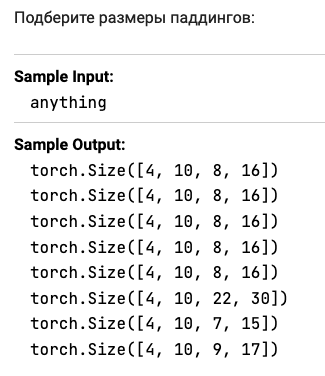

In [5]:
import torch
import math


N = 4
C = 3
C_out = 10
H = 8
W = 16

x = torch.ones((N, C, H, W))

def calc(W, K, W1):
    return math.floor((W1-W+K)/2)

# torch.Size([4, 10, 8, 16])
out1 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=(calc(H,3,8),calc(W,3,16)))(x)
print(out1.shape) # для самопроверки

# torch.Size([4, 10, 8, 16])
out2 = torch.nn.Conv2d(C, C_out, kernel_size=(5, 5), padding=(calc(H,5,8),calc(W,5,16)))(x)
print(out2.shape) # для самопроверки

# torch.Size([4, 10, 8, 16])
out3 = torch.nn.Conv2d(C, C_out, kernel_size=(7, 7), padding=(calc(H,7,8),calc(W,7,16)))(x)
print(out3.shape) # для самопроверки

# torch.Size([4, 10, 8, 16])
out4 = torch.nn.Conv2d(C, C_out, kernel_size=(9, 9), padding=(calc(H,9,8),calc(W,9,16)))(x)
print(out4.shape) # для самопроверки

# torch.Size([4, 10, 8, 16])
out5 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 5), padding=(calc(H,3,8),calc(W,5,16)))(x)
print(out5.shape) # для самопроверки

# torch.Size([4, 10, 22, 30])
out6 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=(calc(H,3,22),calc(W,3,30)))(x)
print(out6.shape) # для самопроверки

# torch.Size([4, 10, 7, 15])
out7 = torch.nn.Conv2d(C, C_out, kernel_size=(4, 4), padding=(calc(H,4,7),calc(W,4,15)))(x)
print(out7.shape) # для самопроверки

# torch.Size([4, 10, 9, 17])
out8 = torch.nn.Conv2d(C, C_out, kernel_size=(2, 2), padding=(calc(H,2,9),calc(W,2,17)))(x)
print(out8.shape) # для самопроверки

torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 22, 30])
torch.Size([4, 10, 7, 15])
torch.Size([4, 10, 9, 17])


In [3]:
def get_pads(kernel_sizes: list, H_W: list, N=4, C=3, C_out=10, H=8, W=16):
    for kernel_size, (H_out, W_out) in zip(kernel_sizes, H_W):
        pad_0 = (H_out - H + kernel_size[0] - 1) // 2
        pad_1 = (W_out - W + kernel_size[1] - 1) // 2
        print((pad_0, pad_1))


kernel_sizes = [
    (3, 3), (5, 5), (7, 7), (9, 9),
    (3, 5), (3, 3), (4, 4), (2, 2)
]

H_W = [
    (8, 16), (8, 16), (8, 16), (8, 16),
    (8, 16), (22, 30), (7, 15), (9, 17)
]

get_pads(kernel_sizes, H_W)

(1, 1)
(2, 2)
(3, 3)
(4, 4)
(1, 2)
(8, 8)
(1, 1)
(1, 1)


# Вопрос 6

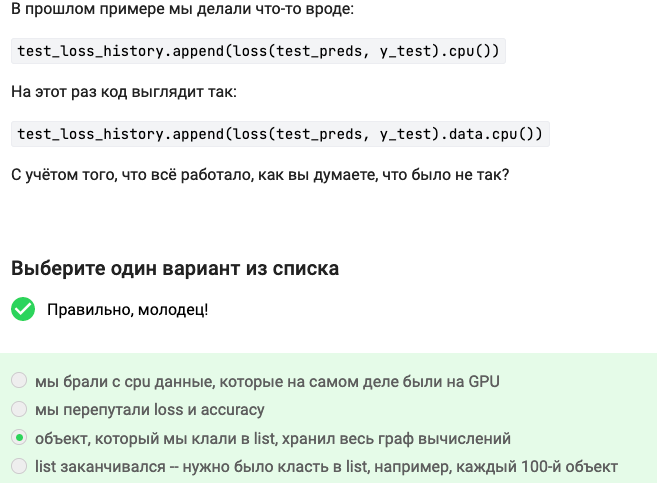